In [ ]:
!pip install transformers==4.30.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


# BERT from Scratch

In [3]:
config = {
    "vocab_size": 30522,  # From bert-base-uncased tokenizer
    "hidden_size": 768,   # Embedding dimension
    "num_hidden_layers": 2, # Number of layers
    "num_attention_heads": 12, # Number of heads
    "intermediate_size": 768 * 4, # 3072 for Feed-Forward layer
    "max_position_embeddings": 512,
    "type_vocab_size": 2, # For segment embeddings
    "hidden_dropout_prob": 0.1,
    "num_labels": 2
}

## 1. Multi-Head Self-Attention

In [4]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.num_attention_heads = config["num_attention_heads"]
    self.hidden_size = config["hidden_size"]
    self.attention_head_size = self.hidden_size // self.num_attention_heads

    self.q = nn.Linear(self.hidden_size, self.hidden_size)
    self.k = nn.Linear(self.hidden_size, self.hidden_size)
    self.v = nn.Linear(self.hidden_size, self.hidden_size)

    self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    self.out_dense = nn.Linear(self.hidden_size, self.hidden_size)

  def change_dimensions(self, x):
    x_new_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) #(batch_size, seq_len, hidden_size) -> (batch_size, seq_len, num_heads, head_size)
    x = x.view(*x_new_shape)
    x = x.permute(0, 2, 1, 3) #(batch_size, num_heads, seq_len, head_size)
    return x

  def forward(self, hidden_states):
    q_layer = self.q(hidden_states) # (batch_size, seq_len, hidden_size)
    # print(q_layer.shape)
    k_layer = self.k(hidden_states)
    v_layer = self.v(hidden_states)

    q_layer = self.change_dimensions(q_layer)
    # print(q_layer.shape)
    k_layer = self.change_dimensions(k_layer)
    v_layer = self.change_dimensions(v_layer)

    attn_scores = torch.matmul(q_layer, k_layer.transpose(-1, -2)) #(batch_size, num_heads, seq_len, seq_len)
    #attention_scores[..., i, j] represents how much the i-th token should attend to the j-th token
    attn_scores = attn_scores / math.sqrt(self.attention_head_size)

    attn_probs = nn.Softmax(dim=-1)(attn_scores)
    attn_probs = self.dropout(attn_probs)

    ctx_layer = torch.matmul(attn_probs, v_layer) #(batch_size, num_heads, seq_len, head_size)
    # print(ctx_layer.shape)

    ctx_layer = ctx_layer.permute(0, 2, 1, 3).contiguous()
    ctx_layer_new_shape = ctx_layer.size()[:-2] + (self.hidden_size,)
    ctx_layer = ctx_layer.view(*ctx_layer_new_shape)
    # print(ctx_layer.shape)

    attn_output = self.out_dense(ctx_layer)
    print(f"    - Shape of Multi-Head Attention output: {attn_output.shape}")
    return attn_output


## 2. Feed-Forward Layer

In [5]:
class FeedForwardLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.dense1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
    self.activation = nn.GELU()
    self.dense2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
    self.dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, hidden_states):
    intermediate_output = self.dense1(hidden_states)
    intermediate_output = self.activation(intermediate_output)
    intermediate_output = self.dense2(intermediate_output)
    intermediate_output = self.dropout(intermediate_output)
    print(f"    - Shape of Feed-Forward Layer output: {intermediate_output.shape}")
    return intermediate_output


## 3. Transformer Encoder Layer

In [6]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.attention = MultiHeadSelfAttention(config)
    self.ffn = FeedForwardLayer(config)
    self.layer_norm1 = nn.LayerNorm(config["hidden_size"])
    self.layer_norm2 = nn.LayerNorm(config["hidden_size"])
    self.dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, hidden_states):
    #MHSA Block
    attention_output = self.attention(hidden_states)
    # print(attention_output.shape)
    attention_output = self.dropout(attention_output)

    #Residual connection and layernorm
    residual_output1 = self.layer_norm1(hidden_states + attention_output)
    # print(residual_output1.shape)

    #FFN Block
    ffn_output = self.ffn(residual_output1)
    #print(ffn_output.shape)

    #Residual connection and layernorm
    residual_output2 = self.layer_norm2(residual_output1 + ffn_output)

    print(f"  - Shape of Transformer Encoder Layer output: {residual_output2.shape}")
    return residual_output2

## 4. BertModel

In [7]:
class BertModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    #Embedding Layer
    self.tok_emb = nn.Embedding(config["vocab_size"], config["hidden_size"])
    self.pos_emb = nn.Embedding(config["max_position_embeddings"], config["hidden_size"])
    self.typ_emb = nn.Embedding(config["type_vocab_size"], config["hidden_size"])
    self.emb_layernorm = nn.LayerNorm(config["hidden_size"])
    self.emb_dropout = nn.Dropout(config["hidden_dropout_prob"])

    #Stack of Transformer Encoder Layers
    self.enc_layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config["num_hidden_layers"])])

    #Pooler: Takes the output of the [CLS] token
    self.pooler = nn.Sequential(
        nn.Linear(config["hidden_size"], config["hidden_size"]),
        nn.Tanh()
    )
    #Classifier Head
    self.classifier = nn.Linear(config["hidden_size"], config["num_labels"])

  def forward(self, inp_ids, tok_typ_ids=None):
    seq_len = inp_ids.size(1)
    pos_ids = torch.arange(seq_len, dtype=torch.long, device=inp_ids.device)
    pos_ids = pos_ids.unsqueeze(0)

    if tok_typ_ids is None:
      tok_typ_ids = torch.zeros_like(inp_ids)

    tok_emb = self.tok_emb(inp_ids)
    pos_emb = self.pos_emb(pos_ids)
    typ_emb = self.typ_emb(tok_typ_ids)

    print(f"Shape of Token Embeddings: {tok_emb.shape}")
    print(f"Shape of Position Embeddings: {pos_emb.shape}")

    emb = tok_emb + pos_emb + typ_emb
    emb = self.emb_layernorm(emb)
    emb = self.emb_dropout(emb)

    print(f"Shape of Embeddings: {emb.shape}")

    hid_states = emb
    for i, lyr in enumerate(self.enc_layers):
      print("-" * 50)
      print(f"Entering Transformer Encoder Layer {i+1}:")
      hid_states = lyr(hid_states)


    fst_tok_tens = hid_states[:, 0]
    pool_out = self.pooler(fst_tok_tens)

    logits = self.classifier(pool_out)

    return logits


## Tokenize and Test

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentence = "My name is Diganta Mandal. I am enjoying the NLP Course."
inputs = tokenizer(sentence, return_tensors = "pt", padding = True, truncation = True, max_length = config['max_position_embeddings'])
input_ids = inputs['input_ids']
token_type_ids = inputs["token_type_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print(f"Tokens: {tokens}")
print(f"\nTokenized Input IDs: {input_ids}")
print(f"Shape of Input IDs: {input_ids.shape}")

Tokens: ['[CLS]', 'my', 'name', 'is', 'dig', '##anta', 'mandal', '.', 'i', 'am', 'enjoying', 'the', 'nl', '##p', 'course', '.', '[SEP]']

Tokenized Input IDs: tensor([[  101,  2026,  2171,  2003, 10667, 26802, 24373,  1012,  1045,  2572,
          9107,  1996, 17953,  2361,  2607,  1012,   102]])
Shape of Input IDs: torch.Size([1, 17])


In [15]:
model = BertModel(config)
model.eval()


with torch.no_grad():
    print("--- Running Model Forward Pass ---\n")
    logits = model(input_ids, token_type_ids)
    print("\n--- Model Forward Pass Complete ---")


probabilities = nn.Softmax(dim=-1)(logits)

print(f"\nShape of final output (logits): {logits.shape}")
print(f"Output probabilities from the classifier: {probabilities}")

--- Running Model Forward Pass ---

Shape of Token Embeddings: torch.Size([1, 17, 768])
Shape of Position Embeddings: torch.Size([1, 17, 768])
Shape of Embeddings: torch.Size([1, 17, 768])
--------------------------------------------------
Entering Transformer Encoder Layer 1:
    - Shape of Multi-Head Attention output: torch.Size([1, 17, 768])
    - Shape of Feed-Forward Layer output: torch.Size([1, 17, 768])
  - Shape of Transformer Encoder Layer output: torch.Size([1, 17, 768])
--------------------------------------------------
Entering Transformer Encoder Layer 2:
    - Shape of Multi-Head Attention output: torch.Size([1, 17, 768])
    - Shape of Feed-Forward Layer output: torch.Size([1, 17, 768])
  - Shape of Transformer Encoder Layer output: torch.Size([1, 17, 768])

--- Model Forward Pass Complete ---

Shape of final output (logits): torch.Size([1, 2])
Output probabilities from the classifier: tensor([[0.4449, 0.5551]])


In [16]:
# Corrected line using print()
print("\n--- Shape of Each Model Parameter ---\n")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {list(param.shape)}")
        total_params += param.numel()

print(f"\nTotal number of parameters: {total_params:,}")


--- Shape of Each Model Parameter ---

tok_emb.weight: [30522, 768]
pos_emb.weight: [512, 768]
typ_emb.weight: [2, 768]
emb_layernorm.weight: [768]
emb_layernorm.bias: [768]
enc_layers.0.attention.q.weight: [768, 768]
enc_layers.0.attention.q.bias: [768]
enc_layers.0.attention.k.weight: [768, 768]
enc_layers.0.attention.k.bias: [768]
enc_layers.0.attention.v.weight: [768, 768]
enc_layers.0.attention.v.bias: [768]
enc_layers.0.attention.out_dense.weight: [768, 768]
enc_layers.0.attention.out_dense.bias: [768]
enc_layers.0.ffn.dense1.weight: [3072, 768]
enc_layers.0.ffn.dense1.bias: [3072]
enc_layers.0.ffn.dense2.weight: [768, 3072]
enc_layers.0.ffn.dense2.bias: [768]
enc_layers.0.layer_norm1.weight: [768]
enc_layers.0.layer_norm1.bias: [768]
enc_layers.0.layer_norm2.weight: [768]
enc_layers.0.layer_norm2.bias: [768]
enc_layers.1.attention.q.weight: [768, 768]
enc_layers.1.attention.q.bias: [768]
enc_layers.1.attention.k.weight: [768, 768]
enc_layers.1.attention.k.bias: [768]
enc_layers

# Data Preprocessing

## Fakeddit

In [ ]:
print("Loading Fakeddit dataset...")
df_train = pd.read_csv("/kaggle/input/fakeddit-nlp-assignment/all_train.tsv", sep="\t")
df_test = pd.read_csv("/kaggle/input/fakeddit-nlp-assignment/all_test_public.tsv", sep="\t")
df_val = pd.read_csv("/kaggle/input/fakeddit-nlp-assignment/all_validate.tsv", sep="\t")

df_main = pd.concat([df_train, df_test, df_val], ignore_index = True)
df_main = df_main[['id', 'clean_title', '2_way_label']]
print(f"Combined dataset shape: {df_main.shape}")
df_main['clean_tite'] = df_main['clean_title'].astype(str)

Loading Fakeddit dataset...
Combined dataset shape: (1063106, 3)


In [ ]:
print("Loading and processing comments...")
cols_to_load = ["id", "submission_id", "body", "parent_id"]

df_comments = pd.read_csv(
    "/kaggle/input/fakeddit-nlp-assignment/all_comments.tsv/all_comments.tsv",
    sep="\t",
    usecols = cols_to_load
)

df_agg_comments = df_comments.groupby("submission_id")["body"].apply(lambda x: " [SEP] ".join(x.astype(str))).reset_index()
df_agg_comments.rename(columns={"body": "comments_text"}, inplace=True)
df_merged = pd.merge(df_main, df_agg_comments, left_on="id", right_on="submission_id", how="left")
df_merged["comments_text"] = df_merged["comments_text"].fillna('')
df_merged["enriched_text"] = "TITLE: " + df_merged["clean_title"] + " | COMMENTS: " + df_merged["comments_text"]
print("Comments merged and text enriched")


Loading and processing comments...


/tmp/ipykernel_19/2081984640.py:4: DtypeWarning: Columns (1,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv(


Comments merged and text enriched


In [ ]:
print("Original Class Distribution")
print(df_merged["2_way_label"].value_counts())

Original Class Distribution
2_way_label
0    578189
1    484917
Name: count, dtype: int64


In [ ]:
df_true = df_merged[df_merged['2_way_label'] == 0]
df_false = df_merged[df_merged['2_way_label'] == 1]
SAMPLE_SIZE = int(min(len(df_true), len(df_false)) * 0.2)
print(SAMPLE_SIZE)
print(f"Balancing dataset to {SAMPLE_SIZE} samples per class...")
df_true = df_true.sample(n=SAMPLE_SIZE, random_state = 42)
df_false = df_false.sample(n=SAMPLE_SIZE, random_state = 42)
df_balanced = pd.concat([df_true, df_false]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced class distribution...")
print(df_balanced['2_way_label'].value_counts())

96983
Balancing dataset to 96983 samples per class...
Balanced class distribution...
2_way_label
0    96983
1    96983
Name: count, dtype: int64


In [ ]:
X = df_balanced['enriched_text']
y = df_balanced['2_way_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("====Final Split Verification:====")
print("Training set balance:")
print(y_train.value_counts(normalize=True))
print(f"Training set size: {len(y_train)}")
print("\nTesting set balance:")
print(y_test.value_counts(normalize=True))
print(f"Testing set size: {len(y_test)}")

====Final Split Verification:====
Training set balance:
2_way_label
0    0.5
1    0.5
Name: proportion, dtype: float64
Training set size: 155172

Testing set balance:
2_way_label
1    0.5
0    0.5
Name: proportion, dtype: float64
Testing set size: 38794


In [ ]:
print("====Fakeddit Dataset Statistics Report====")
print(f"a. Total number of posts in the original dataset: {len(df_main)}")

print("\nb. Class Distribution in the Final Balanced Dataset:")
balanced_counts = df_balanced['2_way_label'].value_counts()
print(f"\tNon-fake posts (label 0): {balanced_counts.get(0, 0)}")
print(f"\tFake posts (label 1):     {balanced_counts.get(1, 0)}")

print("\nc. Distribution of Posts in Train and Test Sets:")
print(f"\tTotal training posts: {len(y_train)}")
print(f"\tTotal testing posts:  {len(y_test)}")
print("\n\tClass distribution in Training set:")
print("\t", y_train.value_counts().to_string().replace("\n", "\n\t"))
print("\n\tClass distribution in Testing set:")
print("\t", y_test.value_counts().to_string().replace("\n", "\n\t"))

print("\nd. Statistics from comment enrichment:")
posts_with_comments = (df_merged['comments_text'] != '').sum()
print(f"\n  i. Number of posts with at least one comment (original dataset): {posts_with_comments}")

comment_counts_per_post = df_comments.groupby('submission_id').size()
stats_df_original = df_merged.copy()
stats_df_original['comment_count'] = stats_df_original['id'].map(comment_counts_per_post).fillna(0).astype(int)
print("\n  ii. Comment statistics for Fake vs Non-Fake posts (ENTIRE dataset):")
stats_full = stats_df_original.groupby('2_way_label')['comment_count'].agg(['mean', 'std'])
stats_full.index = ['Non-Fake (0)', 'Fake (1)']
print("\t", stats_full.to_string().replace("\n", "\n\t"))

stats_df_balanced = df_balanced.copy()
stats_df_balanced['comment_count'] = stats_df_balanced['id'].map(comment_counts_per_post).fillna(0).astype(int)
stats_balanced = stats_df_balanced.groupby('2_way_label')['comment_count'].agg(['mean', 'std'])
stats_balanced.index = ['Non-Fake (0)', 'Fake (1)']
print("\n  iii. Comment statistics for Fake vs Non-Fake posts (BALANCED dataset):")
print("\t", stats_balanced.to_string().replace("\n", "\n\t"))

====Fakeddit Dataset Statistics Report====
a. Total number of posts in the original dataset: 1063106

b. Class Distribution in the Final Balanced Dataset:
	Non-fake posts (label 0): 96983
	Fake posts (label 1):     96983

c. Distribution of Posts in Train and Test Sets:
	Total training posts: 155172
	Total testing posts:  38794

	Class distribution in Training set:
	 2_way_label
	0    77586
	1    77586

	Class distribution in Testing set:
	 2_way_label
	1    19397
	0    19397

d. Statistics from comment enrichment:

  i. Number of posts with at least one comment (original dataset): 584098

  ii. Comment statistics for Fake vs Non-Fake posts (ENTIRE dataset):
	                    mean        std
	Non-Fake (0)   3.845314  18.067710
	Fake (1)      14.885789  56.057783

  iii. Comment statistics for Fake vs Non-Fake posts (BALANCED dataset):
	                    mean        std
	Non-Fake (0)   3.900086  18.387605
	Fake (1)      14.781364  55.771468


# Fine-tuning BERT Model

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Using GPU: Tesla P100-PCIE-16GB


In [ ]:
print("Loading tokenizer and model for 'bert-base-uncased'...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

MAX_LEN = 512

def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Encoding texts", unit="text"):
        encode_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = MAX_LEN,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        input_ids.append(encode_dict['input_ids'])
        attention_masks.append(encode_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids,attention_masks,labels)

X_train = X_train.fillna("")
X_test = X_test.fillna("")

train_dataset = tokenize_data(X_train.tolist(), y_train.tolist())
test_dataset = tokenize_data(X_test.tolist(), y_test.tolist())

print("Tokenization complete.")


Loading tokenizer and model for 'bert-base-uncased'...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Tokenization complete.


In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 4
OPTIMIZER = "AdamW"

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

print("Starting fine-tuning...")

for epoch_i in range(0,EPOCHS):
    print(f"====Epoch {epoch_i + 1}/{EPOCHS}====")
    total_train_loss = 0
    model.train()

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch_i+1} Training"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids = None,
                        attention_mask = b_input_mask,
                        labels = b_labels)
        loss = outputs.loss
        total_train_loss += loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss/len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.4f}")

print("\n Training Complete!")

Starting fine-tuning...
====Epoch 1/4====


Epoch 1 Training: 100%|██████████| 9699/9699 [2:14:56<00:00,  1.20it/s]


  Average training loss: 0.2137
====Epoch 2/4====


Epoch 2 Training: 100%|██████████| 9699/9699 [2:14:52<00:00,  1.20it/s]


  Average training loss: 0.1429
====Epoch 3/4====


Epoch 3 Training: 100%|██████████| 9699/9699 [2:15:02<00:00,  1.20it/s]


  Average training loss: 0.1006
====Epoch 4/4====


Epoch 4 Training: 100%|██████████| 9699/9699 [2:14:52<00:00,  1.20it/s]


  Average training loss: 0.0678

 Training Complete!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("\nEvaluating on the test set...")
model.eval()
predictions, true_labels = [], []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits=  outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

print("Evaluation complete.")


Evaluating on the test set...


Evaluating: 100%|██████████| 2425/2425 [11:14<00:00,  3.60it/s]


Evaluation complete.


====Test Set Performance Metrics====
      Metric     Score
0   Accuracy  0.936021
1  Precision  0.936696
2     Recall  0.935248
3   F1-Score  0.935972


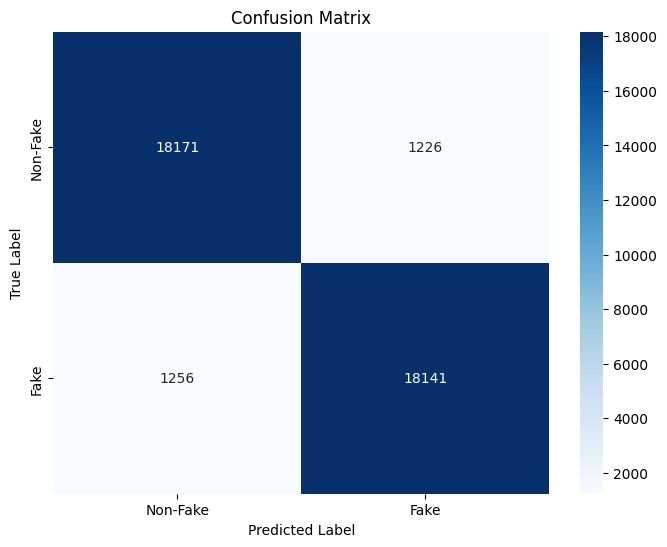

In [ ]:
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)
print("====Test Set Performance Metrics====")
print(metrics_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fake', 'Fake'],
            yticklabels=['Non-Fake', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()